In [1]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
import tensorflow

2024-12-11 21:50:18.441296: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 21:50:18.442976: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 21:50:18.490029: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 21:50:18.490940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 21:50:19.253928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


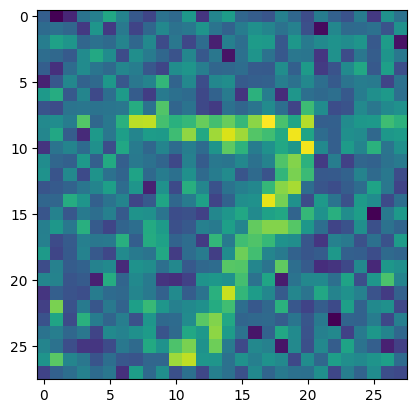

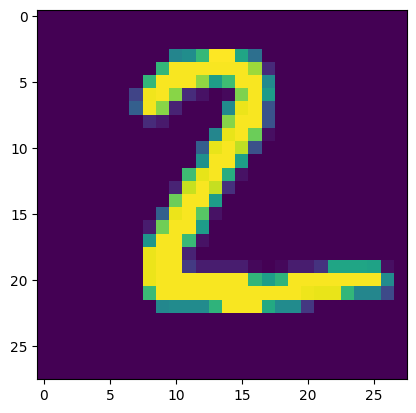

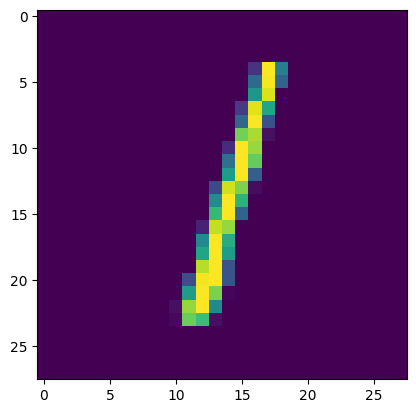

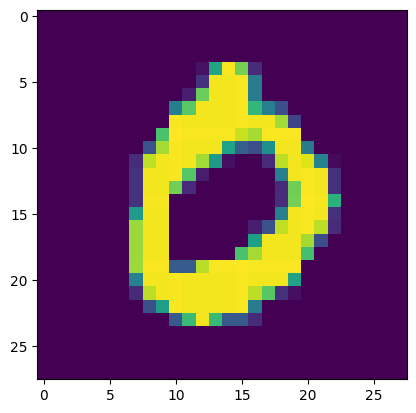

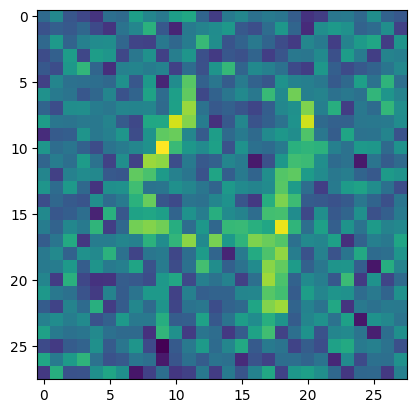

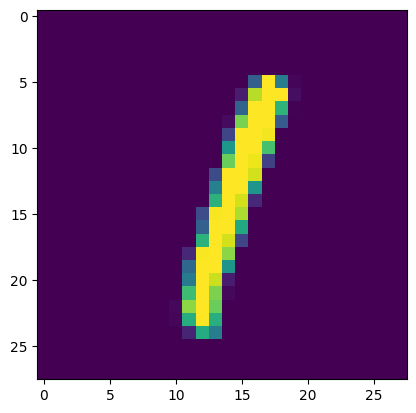

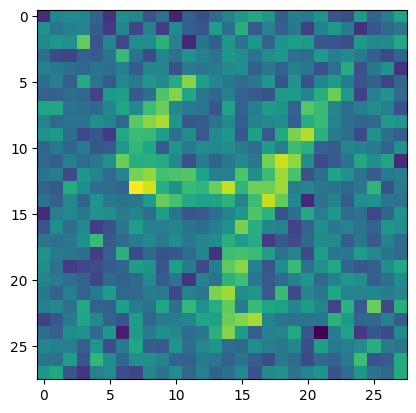

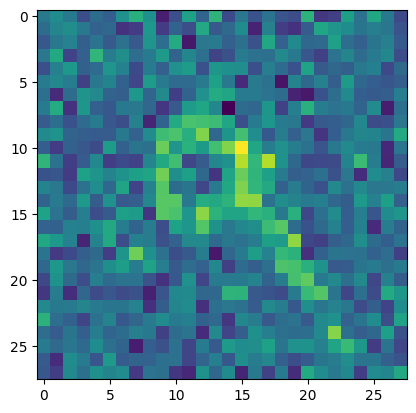

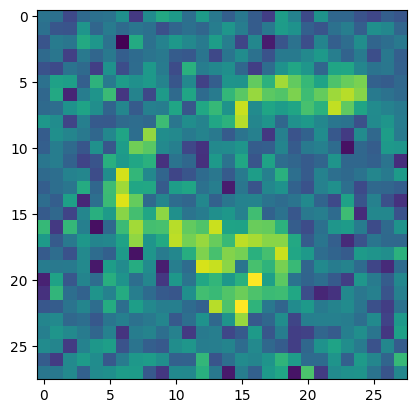

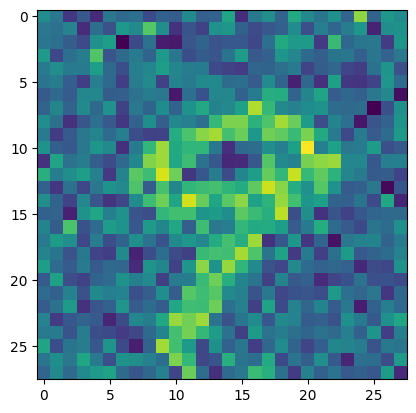

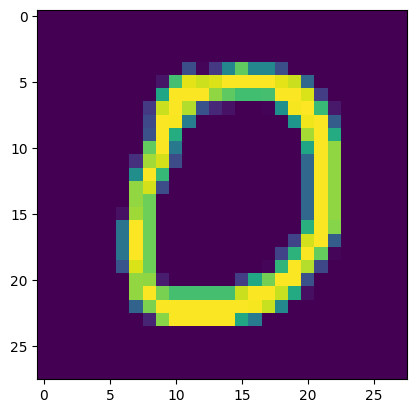

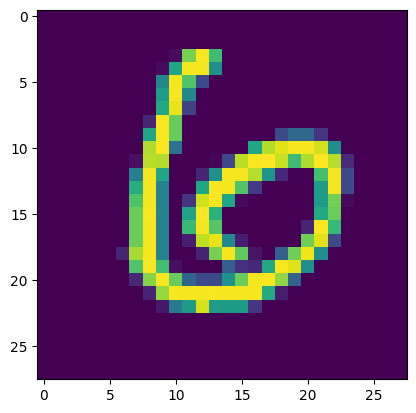

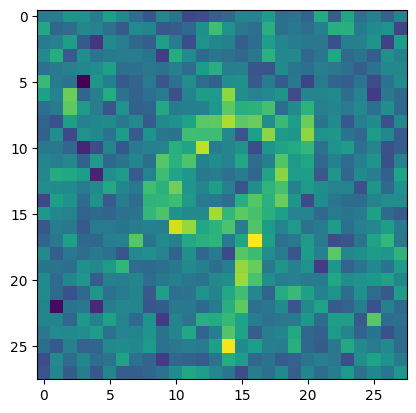

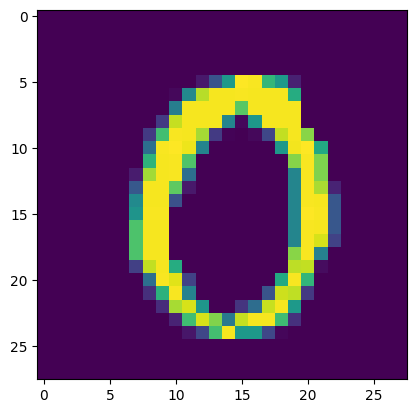

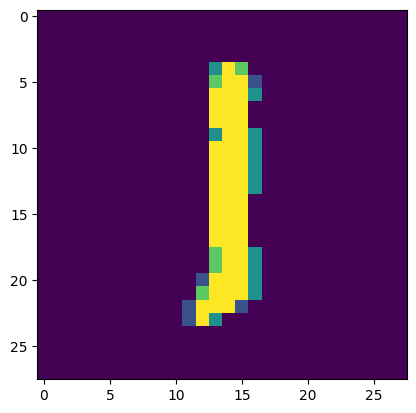

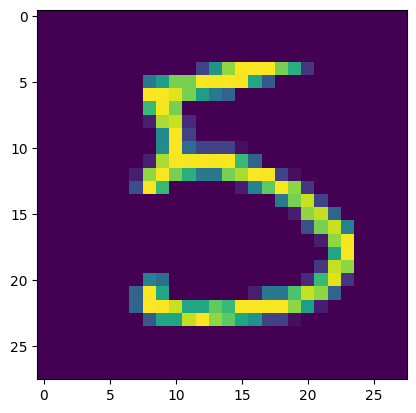

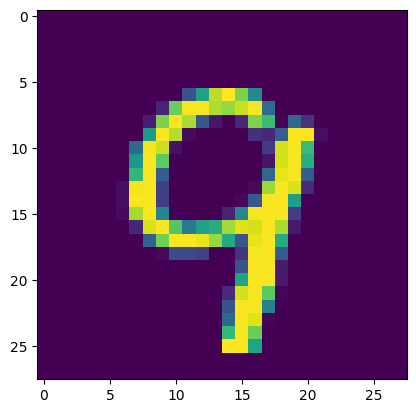

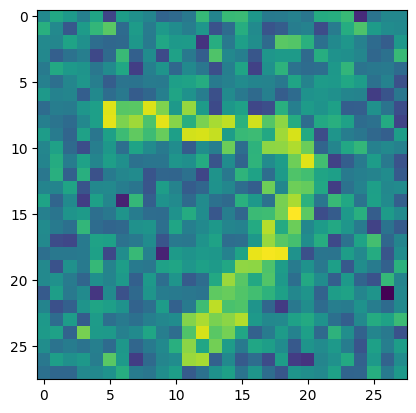

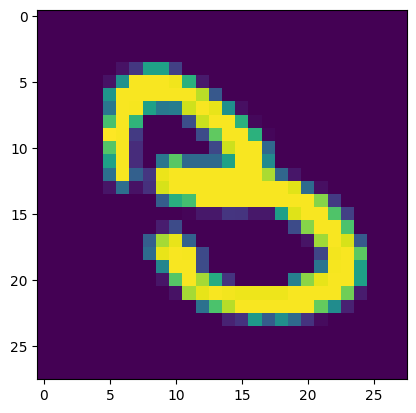

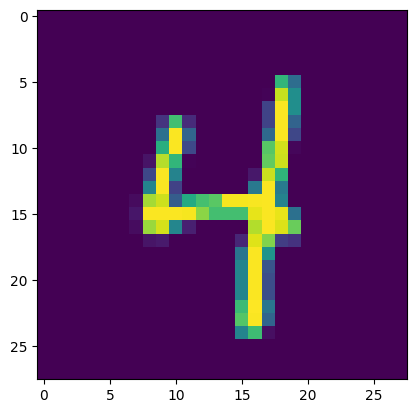

In [2]:
# Loading the dataset. 
(X_train, y_train), (X_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

X_train = X_train.astype(float)
X_test = X_test.astype(float)


X_train /= 255.0
X_test /= 255.0

# Adding noise to some test images.
add_noise = np.random.uniform(0, 1, len(X_test)) < 0.3
noise = np.random.normal(size=X_test.shape) * 0.35

X_test = X_test + np.expand_dims(add_noise, (1, 2)) * noise

X_train = np.expand_dims(X_train, 3)
X_test = np.expand_dims(X_test, 3)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

for x in range(20):
    plt.imshow(X_test[x])
    plt.show()

In [3]:
class Autoencoder(keras.Model):
    def __init__(self):
        super().__init__()

        self.encoder = keras.Sequential()
        self.encoder.add(keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu"))
        self.encoder.add(keras.layers.Conv2D(filters=4, kernel_size=3, activation="relu"))

        self.decoder = keras.Sequential()
        self.decoder.add(keras.layers.Conv2DTranspose(filters=4, kernel_size=3, activation="relu"))
        self.decoder.add(keras.layers.Conv2DTranspose(filters=8, kernel_size=3, activation="relu"))
        self.decoder.add(keras.layers.Conv2D(filters=1, kernel_size=1, activation="sigmoid"))
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

In [4]:
autoencoder = Autoencoder()
sample = np.zeros((10, 28, 28,1))
print(autoencoder(sample).shape)

(10, 28, 28, 1)


In [5]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(loss=keras.losses.MeanSquaredError(), optimizer=opt)
history = autoencoder.fit(x=X_train, y=X_train, epochs=10, batch_size=64, validation_data=(X_test, X_test))

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0866 - val_loss: 0.0524
Epoch 2/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0090 - val_loss: 0.0428
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0043 - val_loss: 0.0394
Epoch 4/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0028 - val_loss: 0.0376
Epoch 5/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0019 - val_loss: 0.0358
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0013 - val_loss: 0.0342
Epoch 7/10
938/938 [==============================] - 14s 15ms/step - loss: 8.8659e-04 - val_loss: 0.0331
Epoch 8/10
938/938 [==============================] - 13s 14ms/step - loss: 6.6950e-04 - val_loss: 0.0326
Epoch 9/10
938/938 [==============================] - 9s 9ms/step - loss: 5.6042e-04 - val_loss: 0.0325
Epoch 10/10
938/938 [==============================] - 9s 9ms/step - loss: 5.0241e

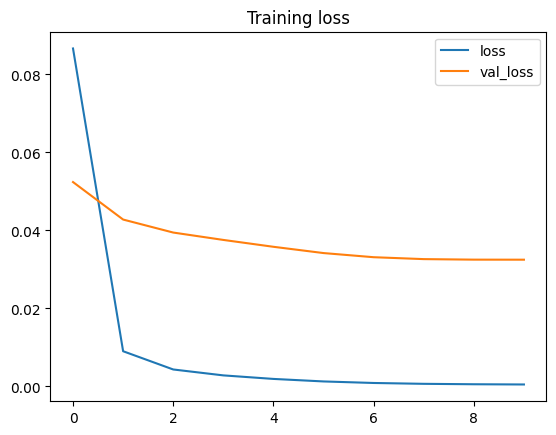

In [6]:
plt.title("Training loss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()


In [7]:
train_reconstructed = autoencoder(X_train) 
test_reconstructed = autoencoder(X_test) 

train_errors = np.mean((X_train - train_reconstructed) ** 2, axis=(1, 2, 3))
test_errors = np.mean((X_test - test_reconstructed) ** 2, axis=(1, 2, 3))

mean_training_error = np.mean(train_errors)
print("Mean training error: ", mean_training_error)

predictions = test_errors > mean_training_error
print("Predictions on the training set with added noise: ", balanced_accuracy_score(add_noise, predictions))

Mean training error:  0.00048147986
Predictions on the training set with added noise:  0.8329703832752613


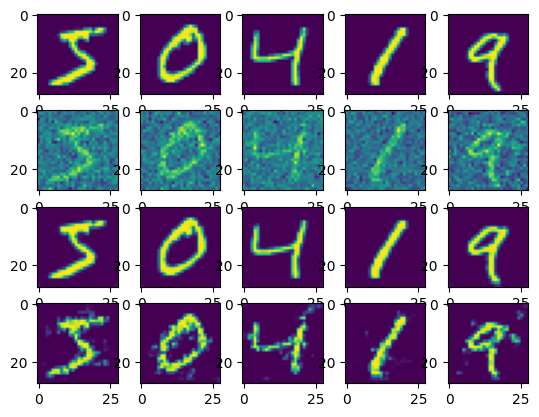

In [8]:
test_images = X_train[:5]
fig, axs = plt.subplots(4, 5)

noise = np.random.normal(size=test_images.shape) * 0.35
add_noise = test_images + noise 

for i in range(5):
    axs[0,i].imshow(test_images[i])

for i in range(5):
    axs[1,i].imshow(add_noise[i])

for i in range(5):
    image = np.expand_dims(test_images[i], 0)
    reconstructed = autoencoder(image)

    axs[2,i].imshow(np.squeeze(reconstructed))

for i in range(5):
    image = np.expand_dims(add_noise[i], 0)
    reconstructed = autoencoder(image)

    axs[3,i].imshow(np.squeeze(reconstructed))

In [9]:
autoencoder = Autoencoder()
opt = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(loss=keras.losses.MeanSquaredError(), optimizer=opt)

noise_train = np.random.normal(size=X_train.shape) * 0.35
noise_test = np.random.normal(size=X_test.shape) * 0.35

history = autoencoder.fit(x=X_train, y=X_train+noise_train, epochs=10, batch_size=64, validation_data=(X_test, X_test+noise_test))

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2753 - val_loss: 0.1891
Epoch 2/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1386 - val_loss: 0.1681
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1294 - val_loss: 0.1649
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1276 - val_loss: 0.1628
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1265 - val_loss: 0.1614
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1257 - val_loss: 0.1598
Epoch 7/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1250 - val_loss: 0.1588
Epoch 8/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1246 - val_loss: 0.1579
Epoch 9/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1242 - val_loss: 0.1575
Epoch 10/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1239 - val_loss: 0.1566

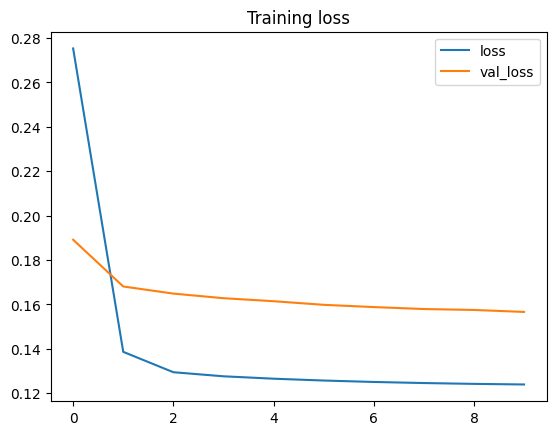

In [10]:
plt.title("Training loss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

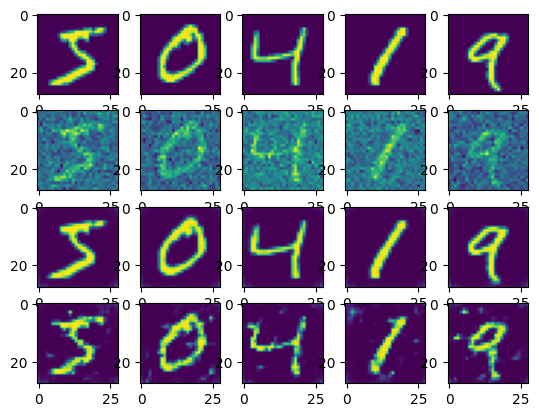

In [11]:
test_images = X_train[:5]
fig, axs = plt.subplots(4, 5)

noise = np.random.normal(size=test_images.shape) * 0.35
add_noise = test_images + noise 

for i in range(5):
    axs[0,i].imshow(test_images[i])

for i in range(5):
    axs[1,i].imshow(add_noise[i])

for i in range(5):
    image = np.expand_dims(test_images[i], 0)
    reconstructed = autoencoder(image)

    axs[2,i].imshow(np.squeeze(reconstructed))

for i in range(5):
    image = np.expand_dims(add_noise[i], 0)
    reconstructed = autoencoder(image)

    axs[3,i].imshow(np.squeeze(reconstructed))